**RPC Efficiency Plotter 02/05**

A new and improved efficiency plotter, now to be used in VSCode.

Adapted in large part from Peter's "Ultimate RPC Plotter Mk 3.02"

In [ ]:
import warnings
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import mplhep as hep
import numpy as np

hep.style.use(hep.style.ATLAS)

In [ ]:
class CSVPlotterApp:
    def __init__(self, master):
        self.master = master
        master.title("RPC Efficiency Plotter")
        self.frame = ttk.Frame(master)
        self.frame.pack(padx=10, pady=10)

        self.load_button = ttk.Button(self.frame, text="Load Folder", command=self.load_folder)
        self.load_button.pack(pady=5)

        self.csv_files = {}

    def load_folder(self):
            folder_path = filedialog.askdirectory(title="Select Folder Containing CSV Files")
            if not folder_path:
                return

            for widget in self.frame.winfo_children():
                widget.destroy()

            self.load_button = ttk.Button(self.frame, text="Load Folder", command=self.load_folder)
            self.load_button.pack(pady=5)

            self.csv_files = {}
            files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
            if not files:
                messagebox.showinfo("No CSV Files", "No CSV files found in the selected folder.")
                return

            for file in files:
                self.csv_files[file] = tk.BooleanVar()
                chk = ttk.Checkbutton(self.frame, text=file, variable=self.csv_files[file])
                chk.pack(anchor='w')

            self.plot_button = ttk.Button(self.frame, text="Plot Selected", command=lambda: self.plot_selected(folder_path))
            self.plot_button.pack(pady=5)

            # Additional UI elements for manual threshold and initial guess values
            self.manual_threshold_var = tk.DoubleVar()
            self.manual_threshold_entry = ttk.Entry(self.frame, textvariable=self.manual_threshold_var)
            self.manual_threshold_entry.pack(pady=5)
            self.manual_threshold_label = ttk.Label(self.frame, text="Manual Threshold Voltage (kV):")
            self.manual_threshold_label.pack(pady=5)

            self.initial_guess_a_var = tk.DoubleVar(value=1.0)
            self.initial_guess_b_var = tk.DoubleVar(value=0.1)
            self.initial_guess_c_var = tk.DoubleVar(value=0.0)
            self.initial_guess_entries = {
                'a': ttk.Entry(self.frame, textvariable=self.initial_guess_a_var),
                'b': ttk.Entry(self.frame, textvariable=self.initial_guess_b_var),
                'c': ttk.Entry(self.frame, textvariable=self.initial_guess_c_var)
            }
            for param, entry in self.initial_guess_entries.items():
                entry.pack(pady=2)
                label = ttk.Label(self.frame, text=f"Initial Guess {param}:")
                label.pack(pady=2)

            # Re-adding checkboxes for additional options after folder is selected
            self.error_bar_var = tk.BooleanVar()
            self.error_bar_chk = ttk.Checkbutton(self.frame, text="Add Error Bars", variable=self.error_bar_var)
            self.error_bar_chk.pack(pady=5)

            self.iv_var = tk.BooleanVar()
            self.iv_chk = ttk.Checkbutton(self.frame, text="IV curve", variable=self.error_bar_var)
            self.iv_chk.pack(pady=5)

            self.hv_var = tk.BooleanVar()
            self.hv_chk = ttk.Checkbutton(self.frame, text="Efficiency against HV", variable=self.error_bar_var)
            self.hv_chk.pack(pady=5)

            self.vth_var = tk.BooleanVar()
            self.vth_chk = ttk.Checkbutton(self.frame, text="Efficiency against Vth", variable=self.error_bar_var)
            self.vth_chk.pack(pady=5)

    def plot_selected(self, folder_path):
        selected_files = [file for file, var in self.csv_files.items() if var.get()]
        if not selected_files:
            messagebox.showwarning("No Selection", "No files selected for plotting.")
            return

        plt.figure(figsize=(20, 16)

        for file, color_index in zip(selected_files, range(len(selected_files))):
            data_path = os.path.join(folder_path, file)
            data = pd.read_csv(data_path)
            data = data[data['Current/uA'] > 0]
            data = data.sort_values(by=['Voltage/kV'], ascending=True)

            #Debugging: check shape of data inputted into sns.lineplot
            #print(data['Voltage/kV'].shape)
            #print(data['Current/uA'].shape)

            #print("File:", file)
            #print("Data:", data)

            #colors = plt.cm.rainbow(np.linspace(0, 1.0, len(selected_files)))  # Generate a list of colors.
            colors = ['#b36305', '#e32017', '#ffd300', '#00782a', '#6950a1', '#f3a9bb', '#a0a5a9','#9b0056','#000000','#003688','#0098d4','#95cdba','#00a4a7','#ee7c0e','#94b817','#e21836' ]
            color_index = selected_files.index(file)  # Get the index of the current file
            color = colors[color_index]  # Select the color for the current file
            if color_index % 2 == 0:
                #sns.lineplot(x=data['Voltage/kV'], y=data['Current/uA'], label=file.split(".")[0],marker='o', markersize=5, color=color)
                plt.plot(data['Voltage/kV'], data['Current/uA'], label=file.split(".")[0],marker='o',markersize=5, color=color)
            else:
                #sns.lineplot(x=data['Voltage/kV'], y=data['Current/uA'], label=file.split(".")[0],marker='o', linestyle = '--', markersize=5, color=color) 
                plt.plot(data['Voltage/kV'], data['Current/uA'], label=file.split(".")[0],marker='o',markersize=5, color=color)
            #sns.scatterplot(x=data['Voltage/kV'], y=data['Current/uA'], color=color) 


            if self.fit_lines_var.get():
                if manual_threshold > 0:
                    threshold = manual_threshold
                else:
                    threshold = self.find_best_threshold(data[['Voltage/kV', 'Current/uA']])

                if threshold is not None:
                    linear_data = data[data['Voltage/kV'] <= threshold]
                    if len(linear_data) > 1:
                        linear_fit_params = np.polyfit(linear_data['Voltage/kV'], linear_data['Current/uA'], 1)
                        linear_fit_func = np.poly1d(linear_fit_params)
                        linear_x_vals = np.linspace(data['Voltage/kV'].min(), threshold, 100)
                        label_linear_fit = f'Linear Fit: $y = {linear_fit_params[0]:.2f}x + {linear_fit_params[1]:.2f}$'
                        plt.plot(linear_x_vals, linear_fit_func(linear_x_vals), linestyle="--", label=label_linear_fit)

                    exp_data = data[data['Voltage/kV'] > threshold]
                    if len(exp_data) > 1:
                        try:
                            exp_fit_params, _ = curve_fit(exp_func, exp_data['Voltage/kV'], exp_data['Current/uA'], p0=initial_guesses, maxfev=10000)
                            exp_x_vals = np.linspace(threshold, data['Voltage/kV'].max(), 100)
                            label_exp_fit = f'Exp Fit: $y = {exp_fit_params[0]:.2f} \cdot e^{{{exp_fit_params[1]:.2f}(x-{exp_fit_params[2]:.2f})}}$'
                            plt.plot(exp_x_vals, exp_func(exp_x_vals, *exp_fit_params), linestyle="--", label=label_exp_fit)
                        except RuntimeError as e:
                            messagebox.showwarning("Fit Error", f"Exponential fit failed for {file}: {e}")

            if self.error_bar_var.get():
                errors = data.iloc[:, 2].replace(0, 0.01)
                plt.errorbar(data['Voltage/kV'], data['Current/uA'], yerr=errors, fmt='o', capsize=5, label='_nolegend_', color = color)

        plt.xlabel('Voltage/kV')
        plt.ylim(0)
        plt.ylabel('Current/$\mathrm{\mu} A$')
        plt.title('Threshold Voltage against Current')
        plt.legend()
        plt.show()


if __name__ == "__main__":
    root = tk.Tk()
    app = CSVPlotterApp(root)
    root.mainloop()

In [ ]:
#noOfCsvs = int(input("Number of CSVs to be read: "))

fp= "/content/drive/MyDrive/Part III Project/RPC/Data/Week 15/csv"


In [ ]:
fileNames=[]

#for i in range(noOfCsvs):

files = glob.glob(os.path.join(fp, "*.csv"))
burnFiles = files
for file in burnFiles:
  redunanter, redundant, used = file.partition(fp)
  fileNames.append(used)

print(fileNames)

['/2904 RPC Freon - IV 2904.csv', '/2904 RPC Freon - IV 3004.csv', '/2904 RPC Freon - Efficiency.csv', '/3004 RPC Isobutane - IV 3004.csv', '/3004 RPC Isobutane - HV.csv', '/3004 RPC Isobutane - Vth.csv', '/3004 RPC 90 Isobutane 10 CO2 - IV 3004.csv', '/3004 RPC 90 Isobutane 10 CO2 - Vth.csv', '/3004 RPC 90 Isobutane 10 CO2 - HV.csv', '/3004 RPC 80 Isobutane 20 CO2 - Vth.csv', '/3004 RPC 80 Isobutane 20 CO2 - HV.csv', '/3004 RPC 80 Isobutane 20 CO2 - IV 3004.csv', '/0105 RPC 70 Isobutane 30 CO2 - Vth.csv', '/0105 RPC 70 Isobutane 30 CO2 - IV.csv', '/0105 RPC 70 Isobutane 30 CO2 - HV.csv', '/0105 RPC 90 Freon 10 Isobutane - Efficiency.csv', '/0105 RPC 90 Freon 10 Isobutane - Efficiency2.csv', '/0105 RPC 90 Freon 10 Isobutane - IV.csv', '/0105 RPC 80 Freon 20 Isobutane - IV.csv', '/0105 RPC 80 Freon 20 Isobutane - Efficiency.csv']


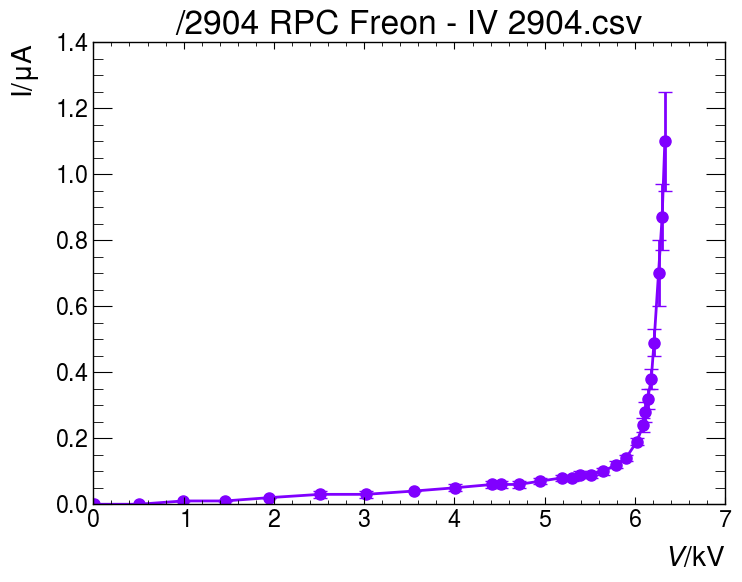

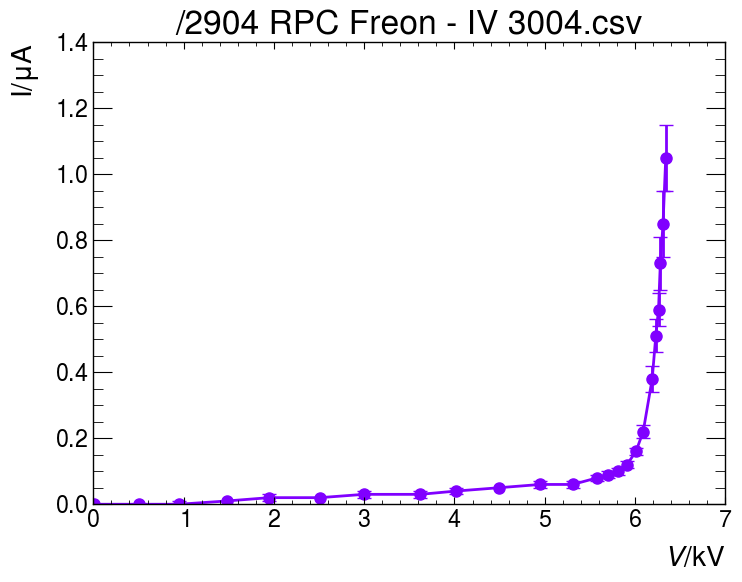

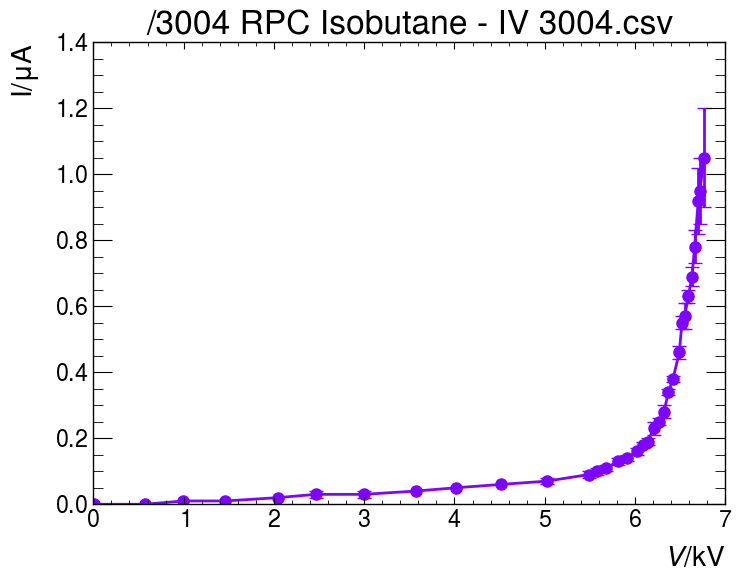

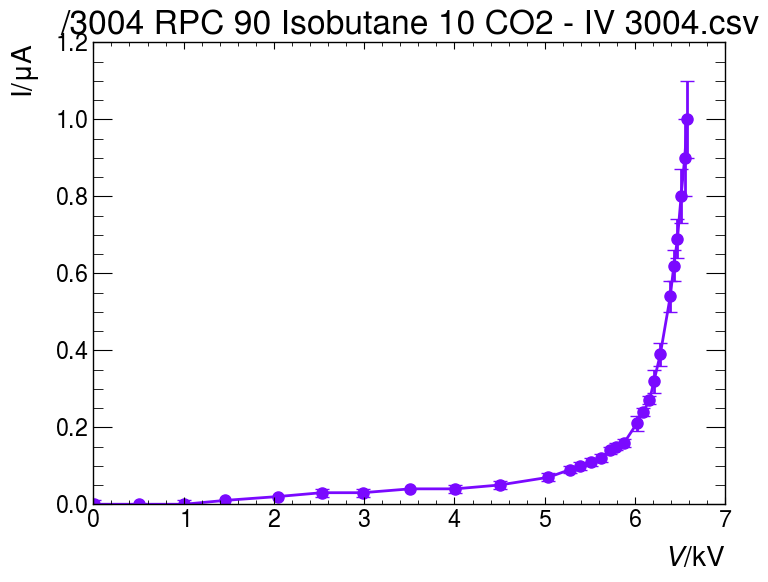

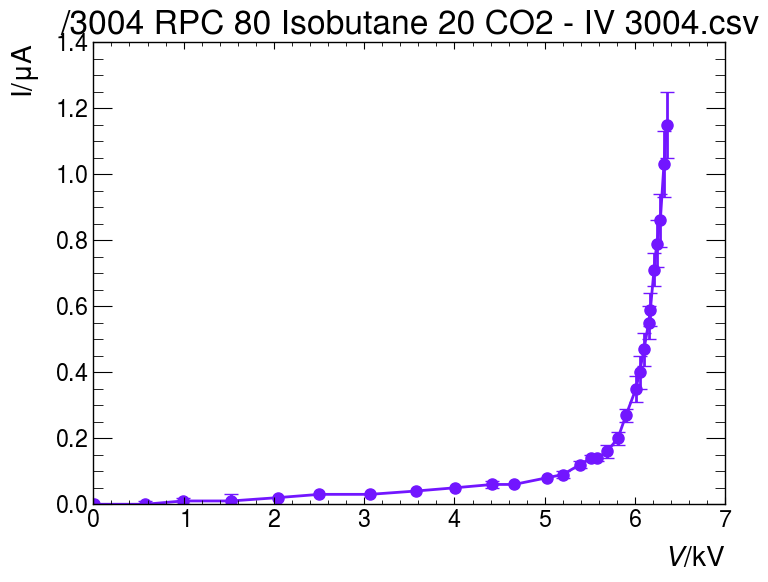

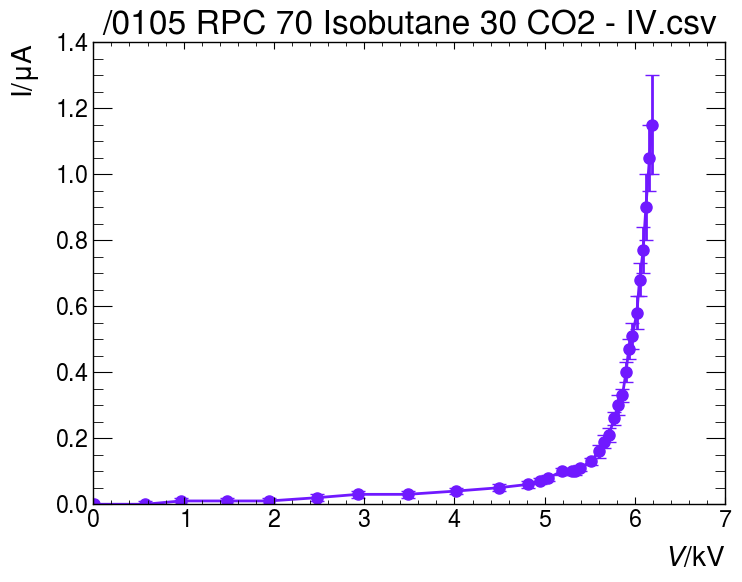

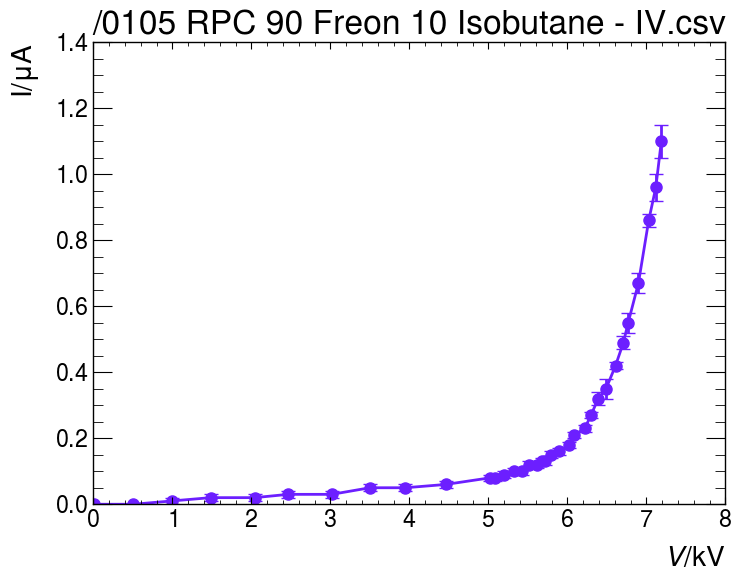

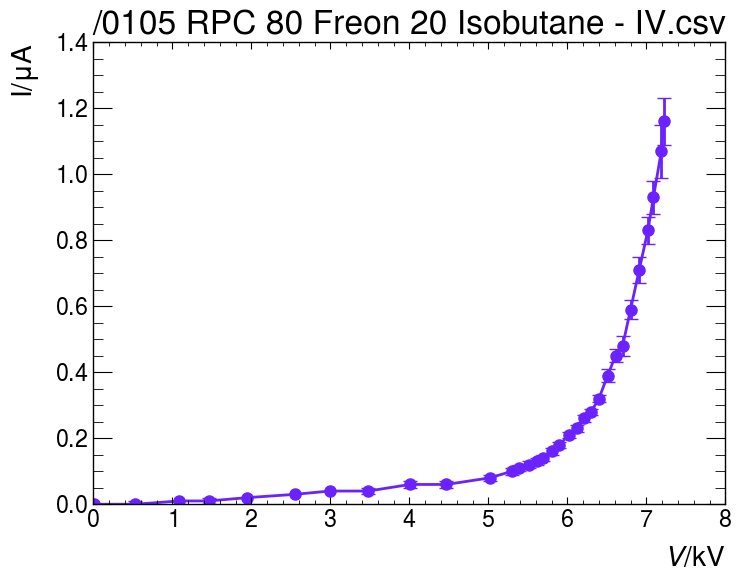

In [ ]:
#IV plot
colors = plt.cm.rainbow(np.linspace(0, 0.25, 100))
i=0

for i in range(len(files)):
  df = pd.read_csv(files[i])
  if 'I/uA' in df.columns and 'Efficiency/%' not in df.columns:
    df = df.sort_values(by=['V/kV'], ascending=True)
    plt.plot(df['V/kV'], df['I/uA'], marker='.', color=colors[i])
    plt.errorbar(df['V/kV'], df['I/uA'], yerr=df['Uncertainty/uA'], fmt='o', capsize=5, label='_nolegend_', color = colors[i])
    plt.xlabel('$V/\mathrm{kV}$')
    plt.ylabel('$\mathrm{I}/\mathrm{\mu A}$')
    plt.ylim(0)
    title = str(fileNames[i])
    plt.title(title)
    plt.savefig(title + '.png')
    plt.show()

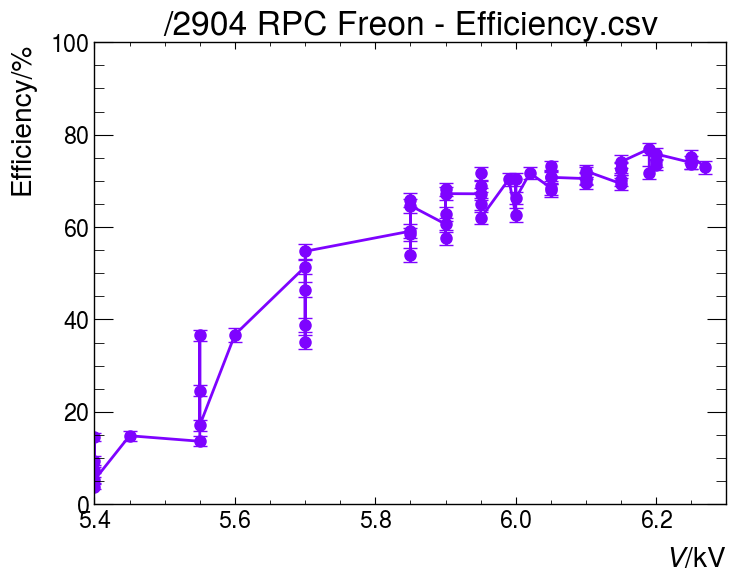

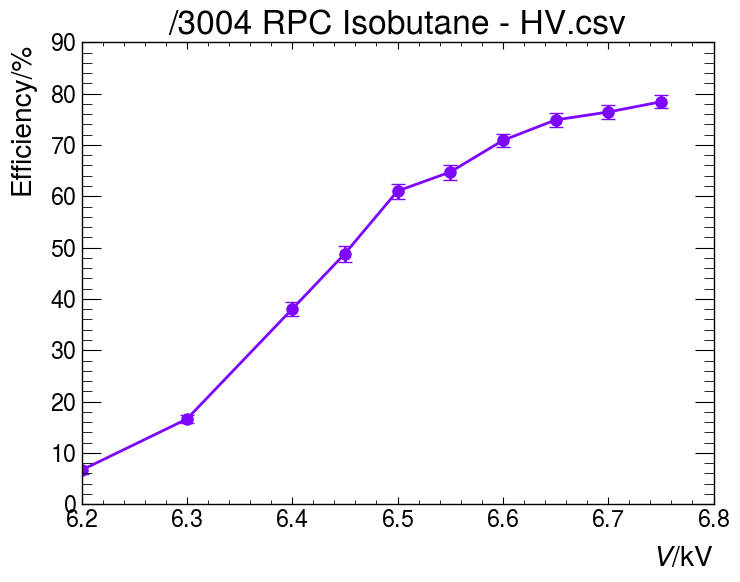

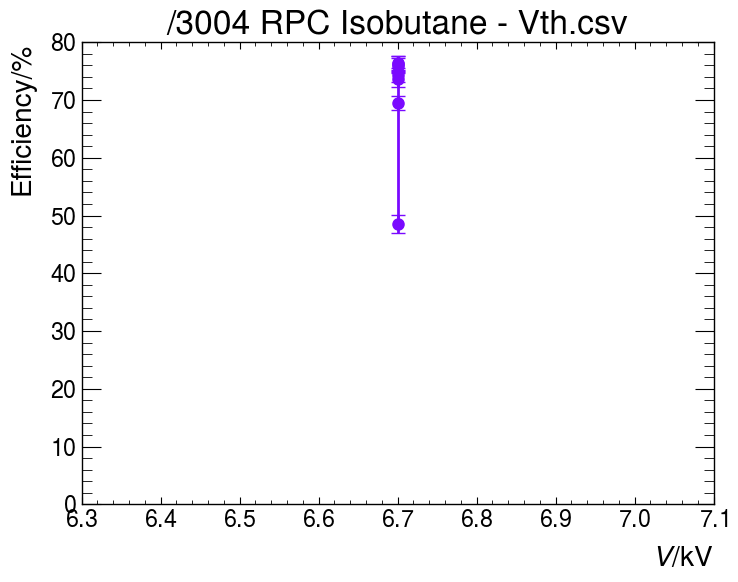

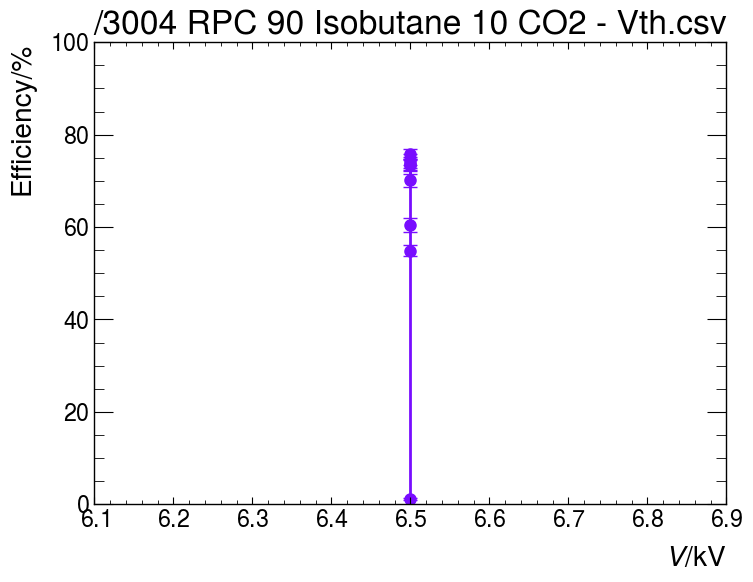

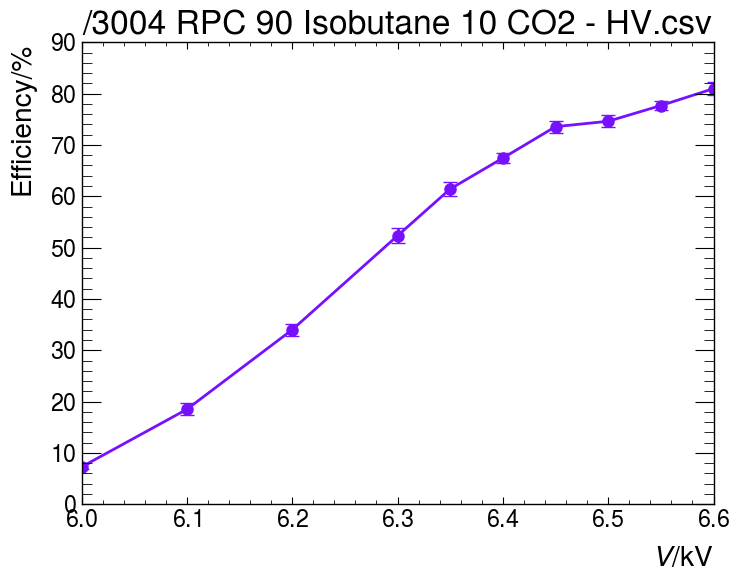

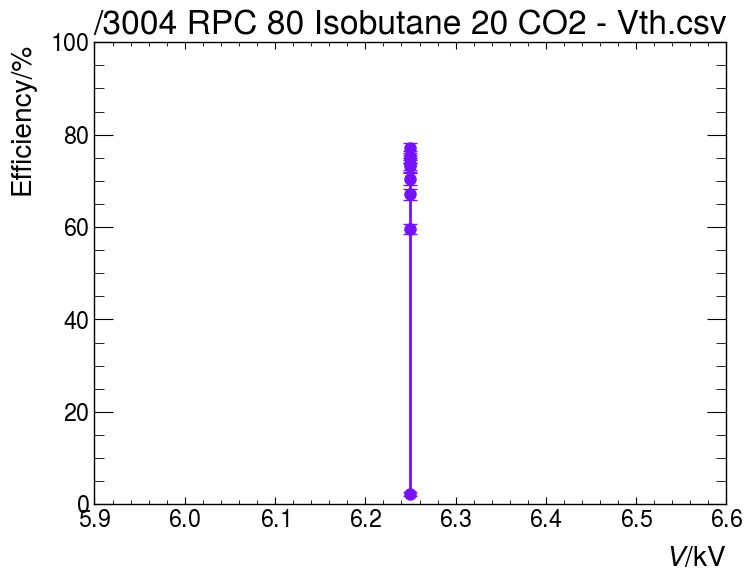

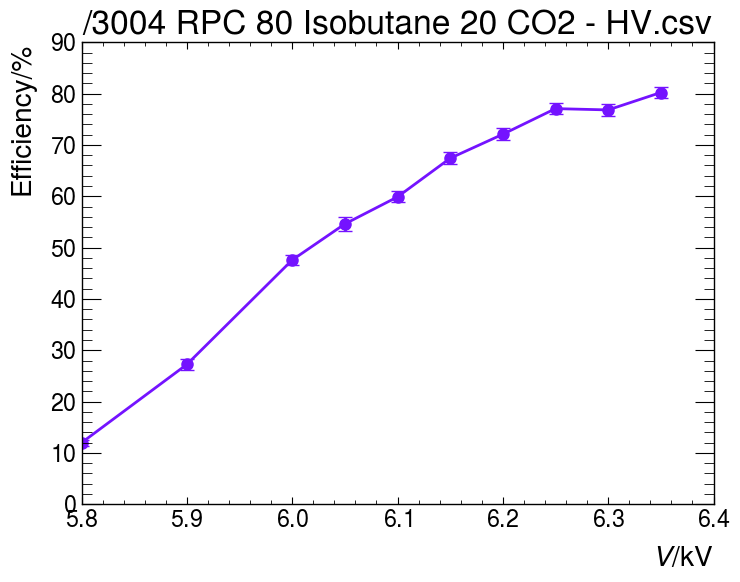

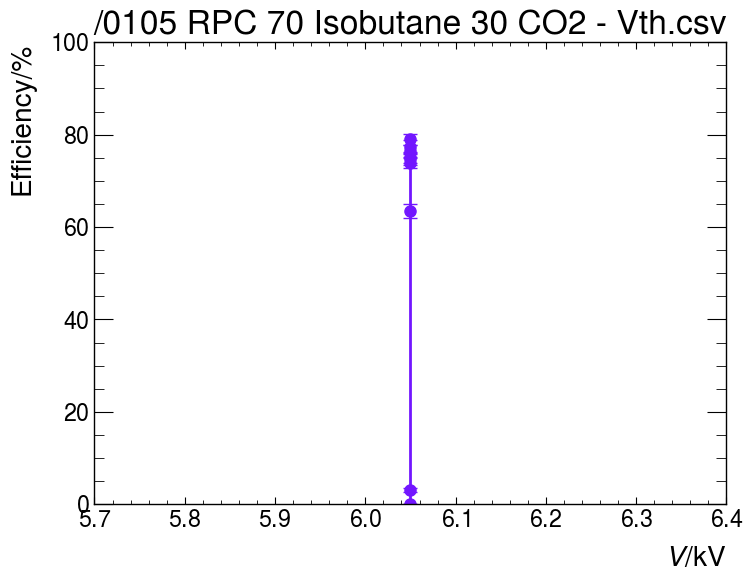

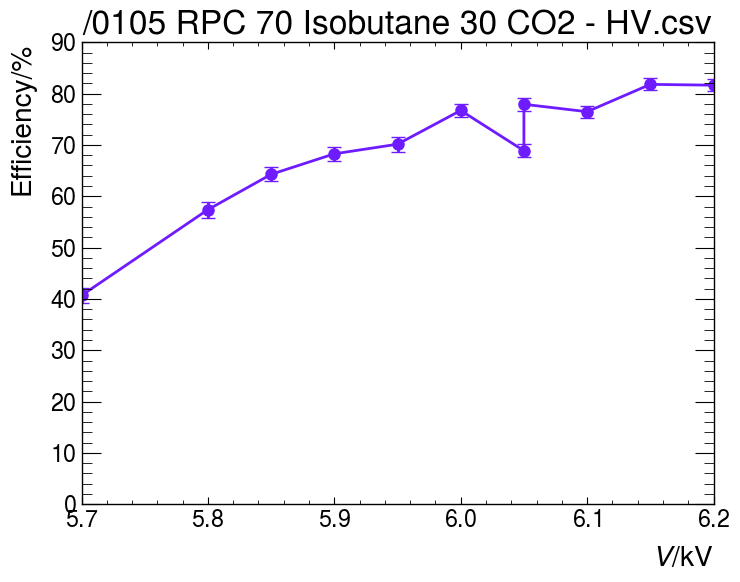

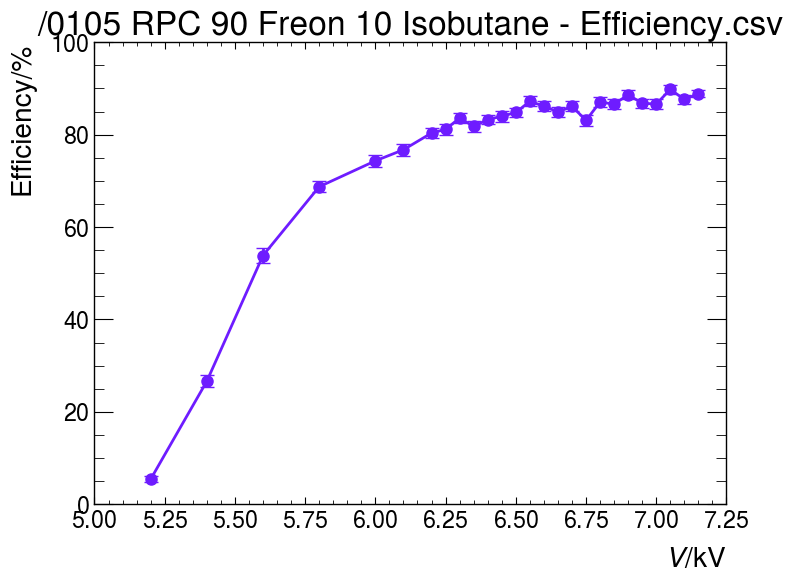

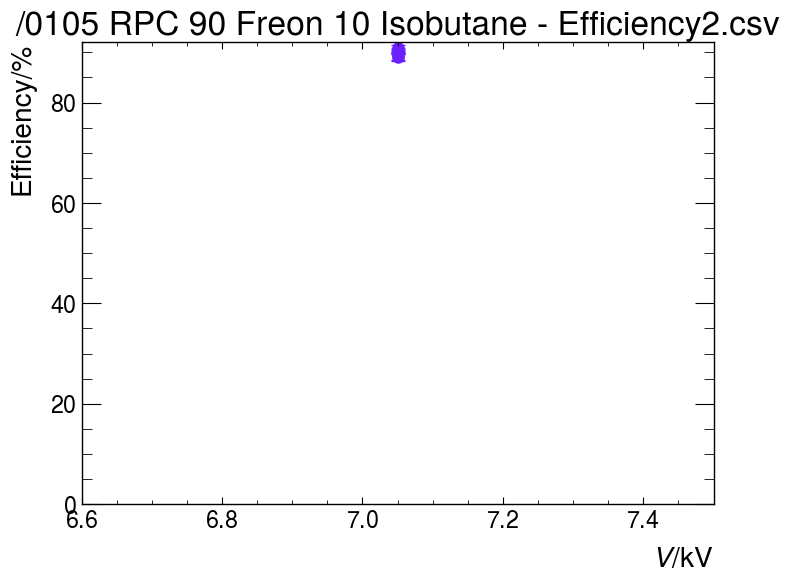

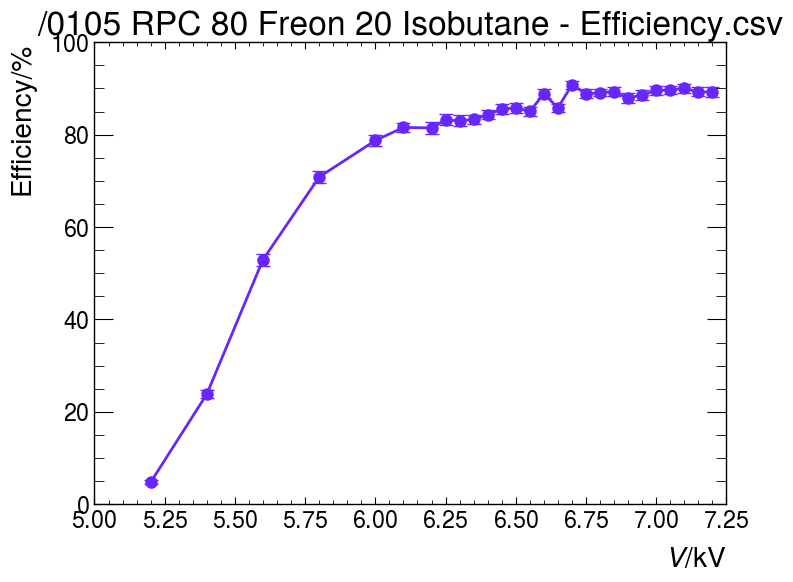

In [27]:
#Efficiency plot


for i in range(len(files)):
  df = pd.read_csv(files[i])
  if 'Numerator' in df.columns:

    df['Efficiency/%'] = df['Numerator']/df['Denominator']*100
    #if 'Vth/V' in df.columns:
    #i=1
    """
    plt.plot(df['Vth/V'], df['Efficiency/%'], marker='.',color=colors[i])
    errors=np.sqrt((df['Efficiency/%']/100*(1-df['Efficiency/%']/100)/df['Denominator']))
    plt.errorbar(df['Vth/V'], df['Efficiency/%'], yerr=errors*100, fmt='o', capsize=5, label='_nolegend_', color = colors[i])
    plt.xlabel('$V_{\mathrm{th}}/\mathrm{V}$')
    plt.ylabel('Efficiency/%')
    plt.title('Efficiency vs $V_{\mathrm{th}}$ 100% Isobutane')
    plt.ylim(0)
    #plt.savefig('Efficiency vs Vth 100% Isobutane 1204.png')
    plt.show()
    """
    #else:

    df = df.sort_values(by=['HV/kV'], ascending=True)
    plt.plot(df['HV/kV'], df['Efficiency/%'], marker='.',color=colors[i])
    errors=np.sqrt((df['Efficiency/%']/100*(1-df['Efficiency/%']/100)/df['Denominator']))
    plt.errorbar(df['HV/kV'], df['Efficiency/%'], yerr=errors*100, fmt='o', capsize=5, label='_nolegend_', color = colors[i])
    plt.xlabel('$V/\mathrm{kV}$')
    plt.ylabel('Efficiency/%')
    title = str(fileNames[i])
    plt.title(title)
    plt.ylim(0)
    plt.savefig(title + '.Effiency.png')
    #plt.savefig('Efficiency vs HV 100% Isobutane 1204.png')
    plt.show()
    """
    i=3
    df = df.sort_values(by=['I/uA'], ascending=True)
    plt.plot(df['I/uA'], df['Efficiency/%'], marker='.', color=colors[i])
    errors=np.sqrt((df['Efficiency/%']/100*(1-df['Efficiency/%']/100)/df['Denominator']))
    plt.errorbar(df['I/uA'], df['Efficiency/%'], yerr=errors*100, fmt='o', capsize=5, label='_nolegend_', color = colors[i])
    plt.xlabel('$I/\mathrm{\mu A}$')
    plt.ylabel('Efficiency/%')
    plt.title('Efficiency vs Current 100% Isobutane')
    plt.ylim(0)
    #plt.savefig('Efficiency vs current 100% Isobutane 1204.png')
    plt.show()
    """


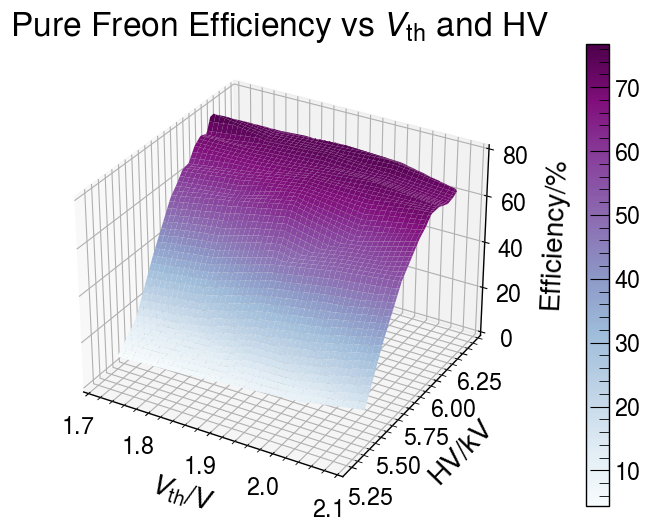

In [19]:
#surface plot

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from IPython.display import HTML

df = pd.read_csv(files[2]) #change if needed (add loop maybe)

# Make data
X = np.array(df['Vth/V'])
Y = np.array(df['HV/kV'])
Z = np.array(df['Efficiency/%'])

# Define a regular grid
xi = np.linspace(X.min(), X.max(), 100)
yi = np.linspace(Y.min(), Y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate the data onto the regular grid
zi = griddata((X, Y), Z, (xi, yi), method='linear')

# Create the surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xi, yi, zi, cmap='BuPu')

# Add labels and title
ax.set_xlabel('$V_{\mathrm{th}}$/V')
ax.set_ylabel('HV/kV')
ax.set_zlabel('Efficiency/%')
ax.set_title('Pure Freon Efficiency vs $V_{\mathrm{th}}$ and HV')

#pad so that colour bar does not end up on top of z axis
fig.colorbar(surf, pad=0.12)


plt.savefig('efficiencyPure Freon.png')

# Show the plot
plt.show()

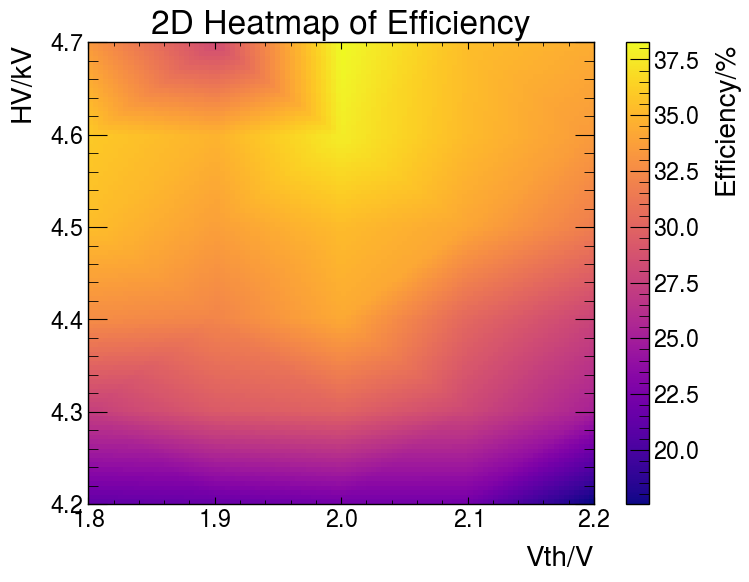

In [ ]:
#heatmap

# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(zi, extent=(X.min(), X.max(), Y.min(), Y.max()), origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label='Efficiency/%')
plt.xlabel('Vth/V')
plt.ylabel('HV/kV')
plt.title('2D Heatmap of Efficiency')
#plt.savefig('efficiencyHeatmap')
plt.show()

    Vth/V  HV/kV  I/uA  Uncertainty/uA  Numerator  Denominator  Efficiency/%
0     1.8    4.2  0.07            0.01       1004         4692         21.40
1     1.8    4.3  0.09            0.01       1002         3647         27.47
2     1.8    4.4  0.13            0.02       1007         3085         32.64
3     1.8    4.5  0.17            0.02       1900         5375         35.35
4     1.8    4.6  0.21            0.02       1576         4381         35.97
5     1.8    4.7  0.28            0.02       1967         5904         33.32
6     1.9    4.2  0.07            0.01       1092         5035         21.69
7     1.9    4.3  0.10            0.02       1880         6406         29.35
8     1.9    4.4  0.13            0.02       1023         3181         32.16
9     1.9    4.5  0.16            0.02       1044         3096         33.72
10    1.9    4.6  0.22            0.02       1029         2955         34.82
11    1.9    4.7  0.29            0.03       1193         4216         28.30

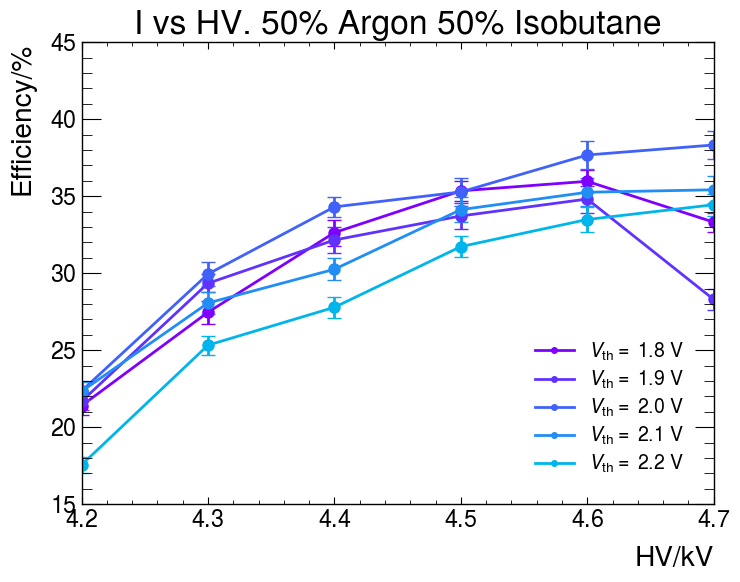

In [ ]:
#contour plot. for each Vth we plot a line on a graph of HV against current.

print(df)

#colors = ['#b36305', '#e32017', '#ffd300', '#00782a', '#6950a1', '#f3a9bb', '#a0a5a9','#9b0056','#000000','#003688','#0098d4','#95cdba','#00a4a7','#ee7c0e','#94b817','#e21836' ]
colors = plt.cm.rainbow(np.linspace(0, 0.25, 5))

for i in range(5):
  vthRange=[1.8,1.9,2.0,2.1,2.2]
  d = df.loc[df["Vth/V"] == vthRange[i]]
  lab='$V_{\mathrm{th}} =$ ' + str(vthRange[i]) + ' V'
  plt.plot(d['HV/kV'],d['Efficiency/%'], marker='.', label = lab, color=colors[i])
  errors=np.sqrt((d['Efficiency/%']/100*(1-d['Efficiency/%']/100)/d['Denominator']))
  plt.errorbar(d['HV/kV'], d['Efficiency/%'], yerr=errors*100, fmt='o', capsize=5, label='_nolegend_', color = colors[i])
plt.title('I vs HV. 50% Argon 50% Isobutane')
plt.xlabel('HV/kV')
plt.ylabel('Efficiency/%')
plt.legend()

plt.savefig('contour plot 5050 ibut ar 1504')
plt.show()
